In [1]:
# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import copy
import shap
import lightgbm as lgb
import sklearn.preprocessing 
import sklearn.feature_selection
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats.stats import spearmanr, pearsonr
import sklearn.model_selection as ms
import sklearn.svm as svm
import joblib

In [22]:
from scipy.stats.stats import spearmanr, pearsonr
import scipy.stats
scipy.stats.norm.cdf(-3)

0.0013498980316300933

In [2]:
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 

    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [3]:
# Output result of evaluation
#生成文件可以用于作图（bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc ）
def eval_output(model_perf,output_file):
    with open(output_file,'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [4]:
# Plot AUROC of model
def plot_AUROC(model_perf,output_file):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) #%相当于format方法,格式化输出,替换%***
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")

In [5]:
# Plot AUPRC of model
def plot_AUPRC(model_perf,output_file):
    #get AUPRC,Precision,Recall and threshold
    prc_auc = model_perf["auprc"]
    precision,recall,threshold = model_perf["auprc_curve"]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))#设置figure的宽、长
    plt.plot(recall, precision, color="red",
             lw=lw,#折线图的线条宽度
             label='AUPRC (area = %0.2f)' % prc_auc#图例
            ) 
    plt.plot([0, 1], [1, 0], color="navy", lw=lw, linestyle='--')#对角线
    #设置x、y坐标轴的范围
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    #坐标轴标签
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("AUPRC of Models")
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")

In [6]:
#Random seed
SEED = np.random.seed(2020)
############ Data Processing ###########
print("\n...... Processing Data ......\n")

#Load data
GTEx = pd.read_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/data/GTEx_dataset_mult_outlier_thrchange',sep = '\t')#,index_col=0
#GTEx=GTEx.iloc[:,:-1]
#GTEx=GTEx.sample(5000,random_state=SEED)


...... Processing Data ......



In [7]:
GTEx_feature=GTEx.drop(['SubjectID','GeneName','eoutlier','over_eoutlier','under_eoutlier','aseoutlier','spliceoutlier','outlier'],axis=1)
GTEx_feature

,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,TFBS,EncOCpolIISig,...,EncH3K4Me3,coding,frameshift,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS
0,0.550190,-0.503801,-0.014524,-0.307731,0.160735,0.481219,1.360309,1.098614,-0.197370,-0.137325,...,-0.159200,0,0,0,0,0,0,1,1,-0.040674
1,-0.549351,-0.503801,6.947333,8.460982,1.817598,2.337763,2.442613,2.121563,-0.197370,-0.137325,...,0.008056,0,0,0,1,0,0,1,1,-0.043352
2,0.888511,0.545497,6.709830,4.136635,1.813724,1.310677,2.357488,2.018901,-0.197370,-0.137325,...,0.009729,0,0,0,1,0,0,0,1,-0.028836
3,2.072633,1.070147,-0.363483,0.174191,0.398055,0.156648,0.095594,0.569540,-0.197370,1.042813,...,-0.105678,0,0,0,0,0,0,1,1,0.000035
4,1.226831,1.070147,0.449798,3.836012,1.468558,3.383240,2.126434,2.257223,-0.197370,0.256054,...,1.026647,0,0,0,0,0,0,1,1,0.067120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6009,-0.464771,-0.766125,-0.397834,-0.553779,-1.399053,0.154124,1.104934,-1.768578,-0.197370,-0.137325,...,-0.159200,0,0,0,0,0,0,1,1,-0.046977
6010,1.226831,1.332471,0.209957,0.663744,0.843790,0.517643,0.569862,1.069282,4.129793,-0.137325,...,0.518188,0,0,1,0,0,0,1,1,-0.028900
6011,0.719350,0.545497,0.327327,1.403277,1.065169,0.506103,0.399612,0.397582,5.778236,-0.038981,...,0.462993,0,0,0,0,0,0,1,1,-0.021314
6012,0.465610,0.545497,-0.224139,0.897768,0.950588,0.311721,-1.146016,0.283920,0.008685,-0.137325,...,-0.017032,0,0,0,0,0,0,1,1,-0.036919


## outlier

In [8]:
out=GTEx['outlier']
#Input
X = copy.deepcopy(GTEx_feature)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################
########## Model Construction ##########
print("\n...... Training Model ......\n")

# SVM params
param_dict = {
    "kernel": ['rbf','sigmoid'],# 
    "gamma": [1, 0.1, 0.01],
    "degree":[1,2,3],
    "C":[0.1, 1, 10],
    "random_state":[2020],#
    'probability':[True]
}#参数列表

#Initiate model
model = svm.SVC()#创建一个分类器对象
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型 
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 6),scoring='neg_mean_squared_error',n_jobs=-1)


...... Finished Data Processing ......


...... Training Model ......


...... Evaluating Model ......

[0. 0. 0. ... 0. 0. 0.]


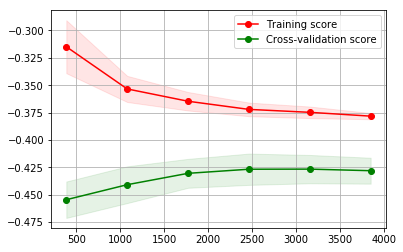

In [9]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

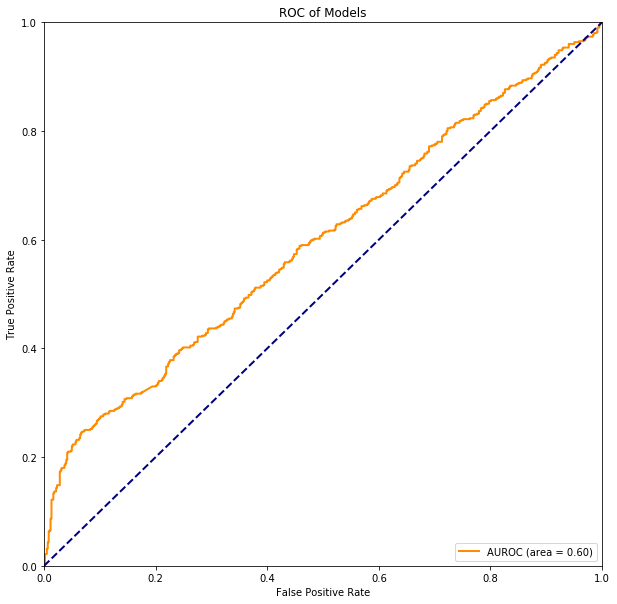

<Figure size 432x288 with 0 Axes>

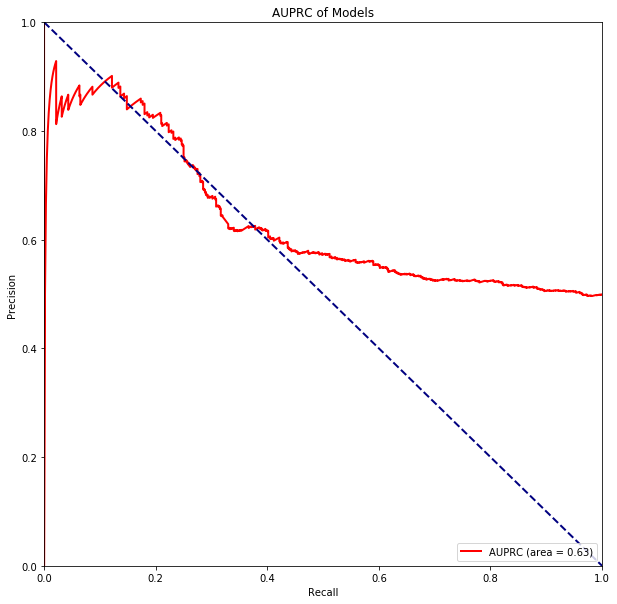

In [10]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet_binerary_svm.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet_binerary_svm.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet_binerary_svm.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

## eoutlier

In [11]:
out=GTEx['eoutlier']
#Input
X = copy.deepcopy(GTEx_feature)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################
########## Model Construction ##########
print("\n...... Training Model ......\n")

# SVM params
param_dict = {
    "kernel": ['rbf','sigmoid'],# 
    "gamma": [1, 0.1, 0.01],
    "degree":[1,2,3],
    "C":[0.1, 1, 10],
    "random_state":[2020],#
    'probability':[True]
}#参数列表

#Initiate model
model = svm.SVC()#创建一个分类器对象
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型 
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 6),scoring='neg_mean_squared_error',n_jobs=-1)


...... Finished Data Processing ......


...... Training Model ......


...... Evaluating Model ......

[0 0 0 ... 0 0 0]


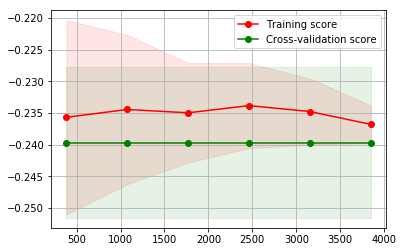

In [12]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Finished Model Evaluation ......



Precision is ill-defined and being set to 0.0 due to no predicted samples.
F-score is ill-defined and being set to 0.0 due to no predicted samples.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


<Figure size 432x288 with 0 Axes>

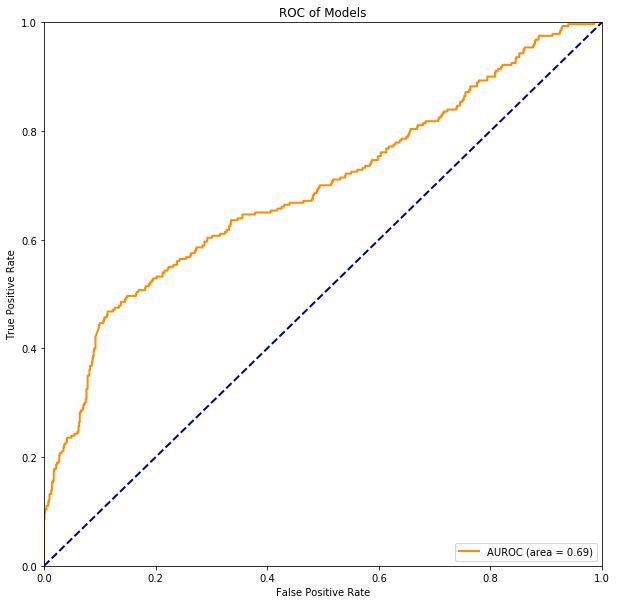

<Figure size 432x288 with 0 Axes>

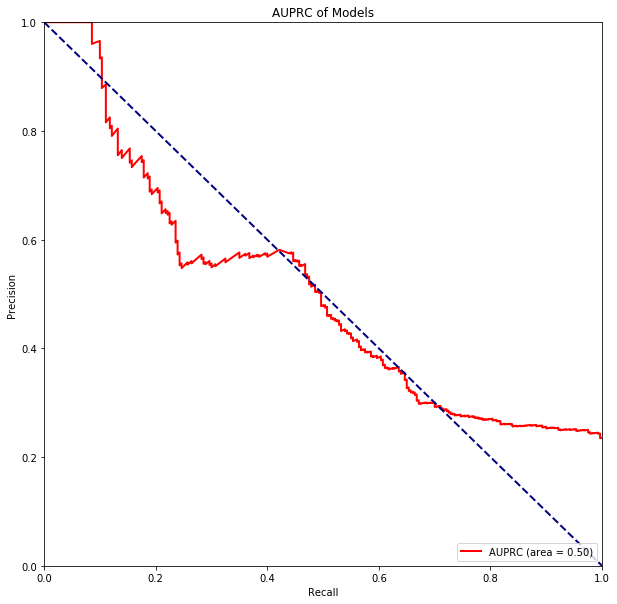

In [13]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet_binerary_svm.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet_binerary_svm.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet_binerary_svm.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

## over_eoutlier

In [14]:
out=GTEx['over_eoutlier']
#Input
X = copy.deepcopy(GTEx_feature)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################
########## Model Construction ##########
print("\n...... Training Model ......\n")

# SVM params
param_dict = {
    "kernel": ['rbf','sigmoid'],# 
    "gamma": [1, 0.1, 0.01],
    "degree":[1,2,3],
    "C":[0.1, 1, 10],
    "random_state":[2020],#
    'probability':[True]
}#参数列表

#Initiate model
model = svm.SVC()#创建一个分类器对象
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型 
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 6),scoring='neg_mean_squared_error',n_jobs=-1)


...... Finished Data Processing ......


...... Training Model ......


...... Evaluating Model ......

[0 0 0 ... 0 0 0]


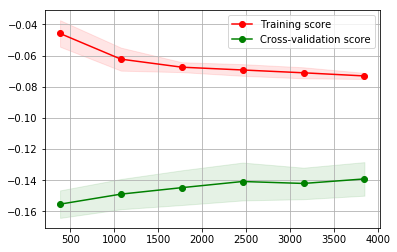

In [15]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

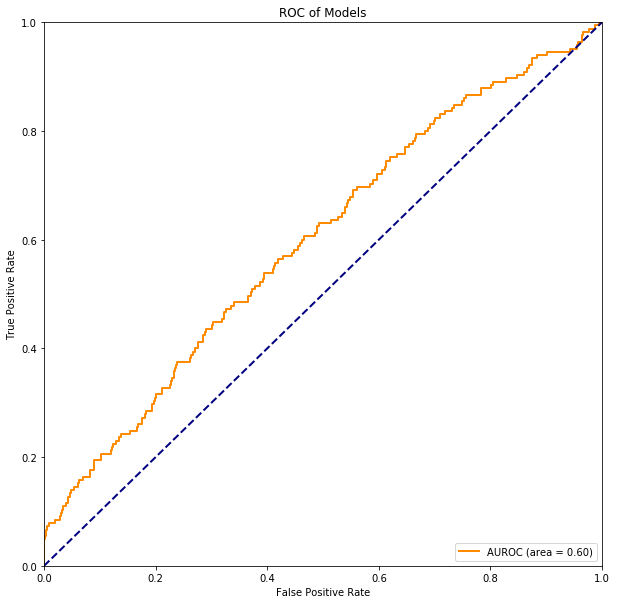

<Figure size 432x288 with 0 Axes>

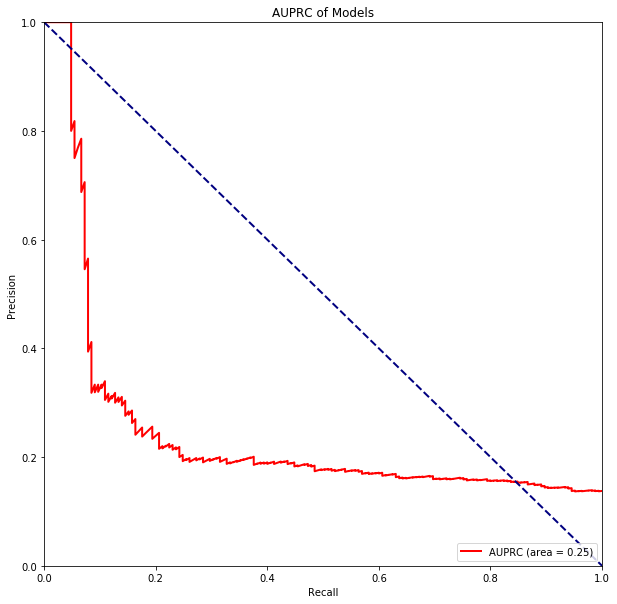

In [16]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet_binerary_svm.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet_binerary_svm.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet_binerary_svm.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

## under_eoutlier

In [17]:
out=GTEx['under_eoutlier']
#Input
X = copy.deepcopy(GTEx_feature)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################
########## Model Construction ##########
print("\n...... Training Model ......\n")

# SVM params
param_dict = {
    "kernel": ['rbf','sigmoid'],# 
    "gamma": [1, 0.1, 0.01],
    "degree":[1,2,3],
    "C":[0.1, 1, 10],
    "random_state":[2020],#
    'probability':[True]
}#参数列表

#Initiate model
model = svm.SVC()#创建一个分类器对象
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型 
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 6),scoring='neg_mean_squared_error',n_jobs=-1)


...... Finished Data Processing ......


...... Training Model ......


...... Evaluating Model ......

[0 1 0 ... 0 0 0]


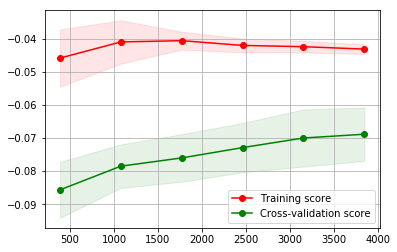

In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

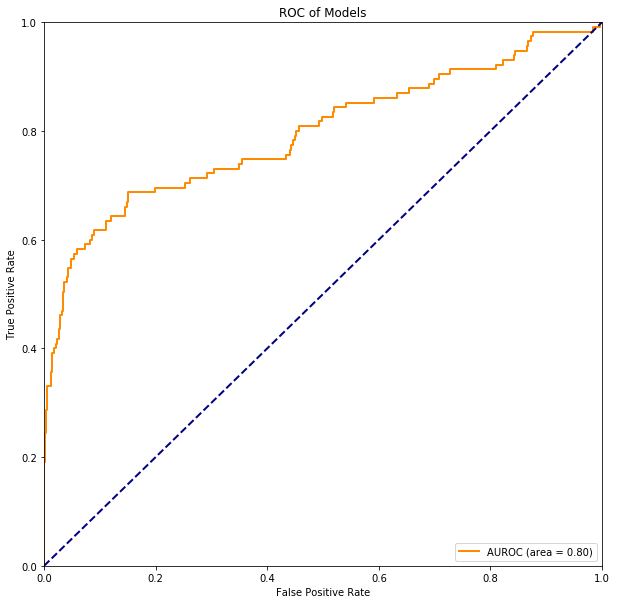

<Figure size 432x288 with 0 Axes>

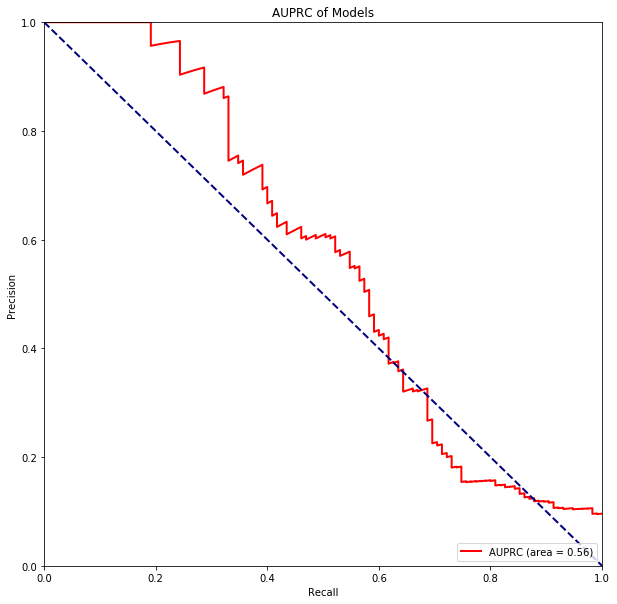

In [19]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet_binerary_svm.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet_binerary_svm.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet_binerary_svm.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

## aseoutlier

In [20]:
out=GTEx['aseoutlier']
#Input
X = copy.deepcopy(GTEx_feature)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################
########## Model Construction ##########
print("\n...... Training Model ......\n")

# SVM params
param_dict = {
    "kernel": ['rbf','sigmoid'],# 
    "gamma": [1, 0.1, 0.01],
    "degree":[1,2,3],
    "C":[0.1, 1, 10],
    "random_state":[2020],#
    'probability':[True]
}#参数列表

#Initiate model
model = svm.SVC()#创建一个分类器对象
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型 
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 6),scoring='neg_mean_squared_error',n_jobs=-1)


...... Finished Data Processing ......


...... Training Model ......


...... Evaluating Model ......

[0 0 0 ... 0 0 0]


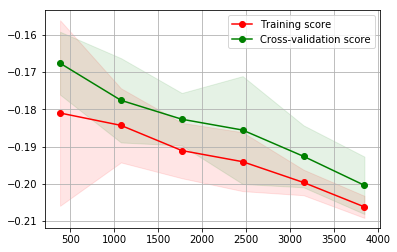

In [21]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

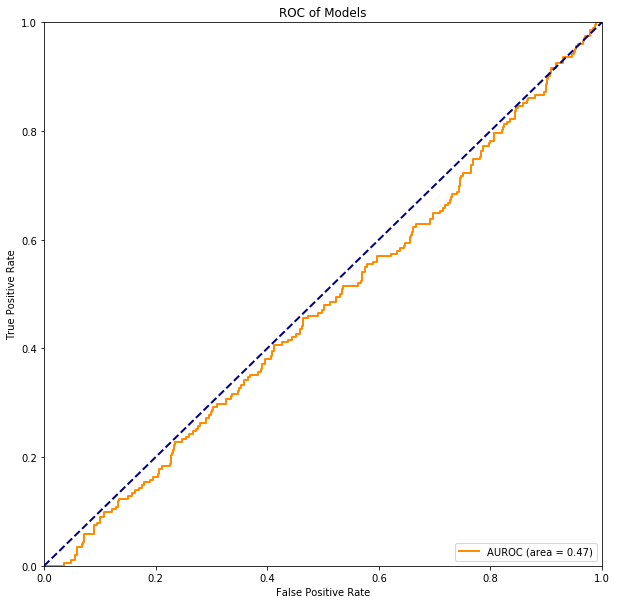

<Figure size 432x288 with 0 Axes>

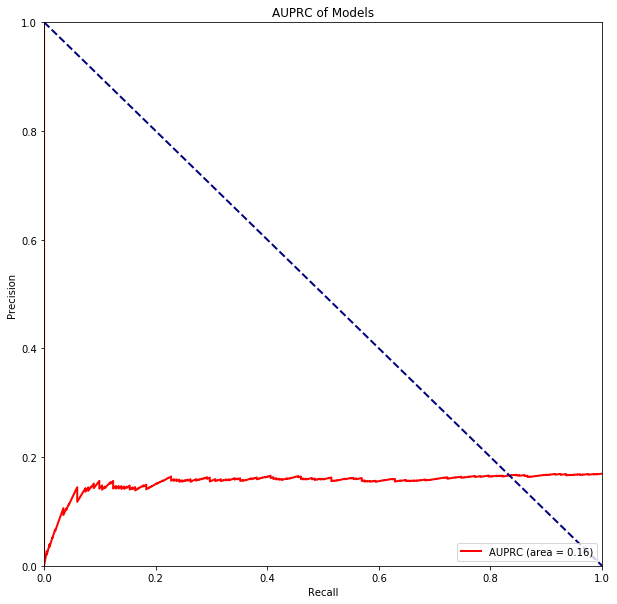

In [22]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet_binerary_svm.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet_binerary_svm.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet_binerary_svm.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

## spliceoutlier

In [23]:
out=GTEx['spliceoutlier']
#Input
X = copy.deepcopy(GTEx_feature)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################
########## Model Construction ##########
print("\n...... Training Model ......\n")

# SVM params
param_dict = {
    "kernel": ['rbf','sigmoid'],# 
    "gamma": [1, 0.1, 0.01],
    "degree":[1,2,3],
    "C":[0.1, 1, 10],
    "random_state":[2020],#
    'probability':[True]
}#参数列表

#Initiate model
model = svm.SVC()#创建一个分类器对象
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型 
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 6),scoring='neg_mean_squared_error',n_jobs=-1)


...... Finished Data Processing ......


...... Training Model ......


...... Evaluating Model ......

[0 0 0 ... 0 0 0]


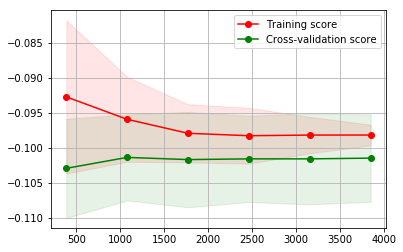

In [24]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

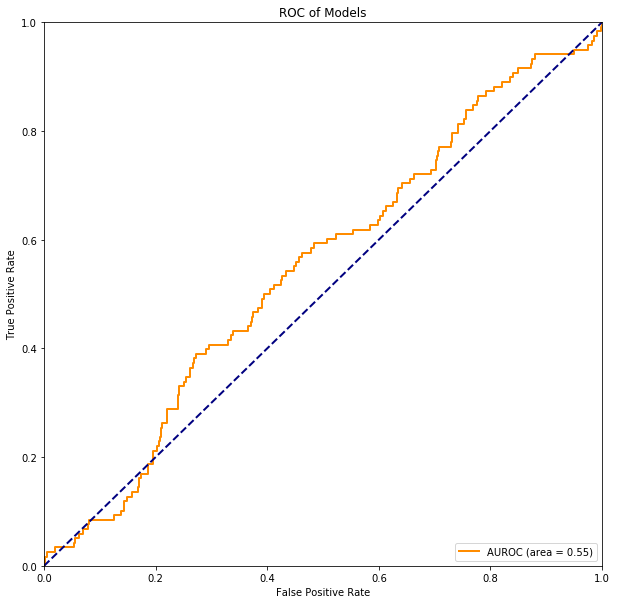

<Figure size 432x288 with 0 Axes>

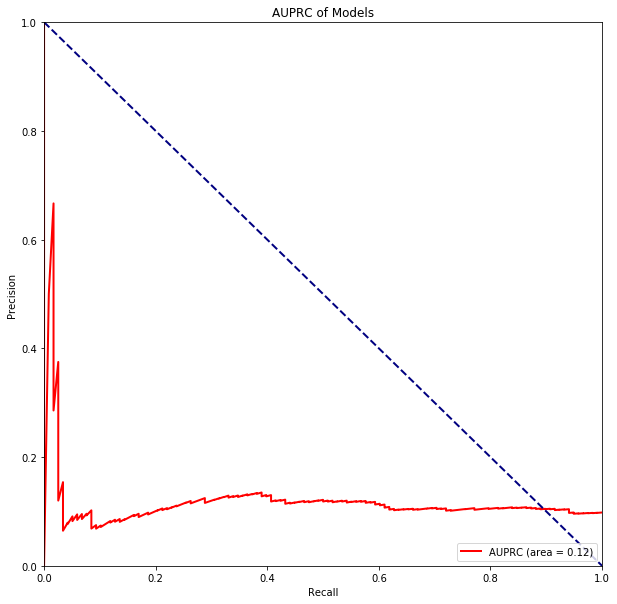

In [25]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet_binerary_svm.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet_binerary_svm.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet_binerary_svm.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################